## ML Exam: 12/09/2022 (Clustering)
1. Load the data file and explore the data, showing size, and data distributions (2pt)
2. drop the columns that are not relevant for the clustering operation, if
any, and explain why you do that (4pt)
3. find the best clustering scheme and compute: a) the quality indexes
usual for clustering and b) the size of the clusters (4pt)
4. apply a data transformation using the preprocessor below (6pt)

`from sklearn.preprocessing import PowerTransformer, StandardScaler`

`from sklearn.pipeline import make_pipeline`

`preprocessor = make_pipeline(
StandardScaler(with_std=False), PowerTransformer(standardize=True)
)`

5. find the best clustering scheme for the transformed data, as done in
step 3 (4pt)
6. show together the results of the two clustering schemes obtained and
comment which of the two is better and why (4pt)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

random_state = 42

url = '/content/income.csv'
df = pd.read_csv(url, index_col=0)

## 1. Load the data file and explore the data, showing size, and data distributions (2pt)

Data size: 78910


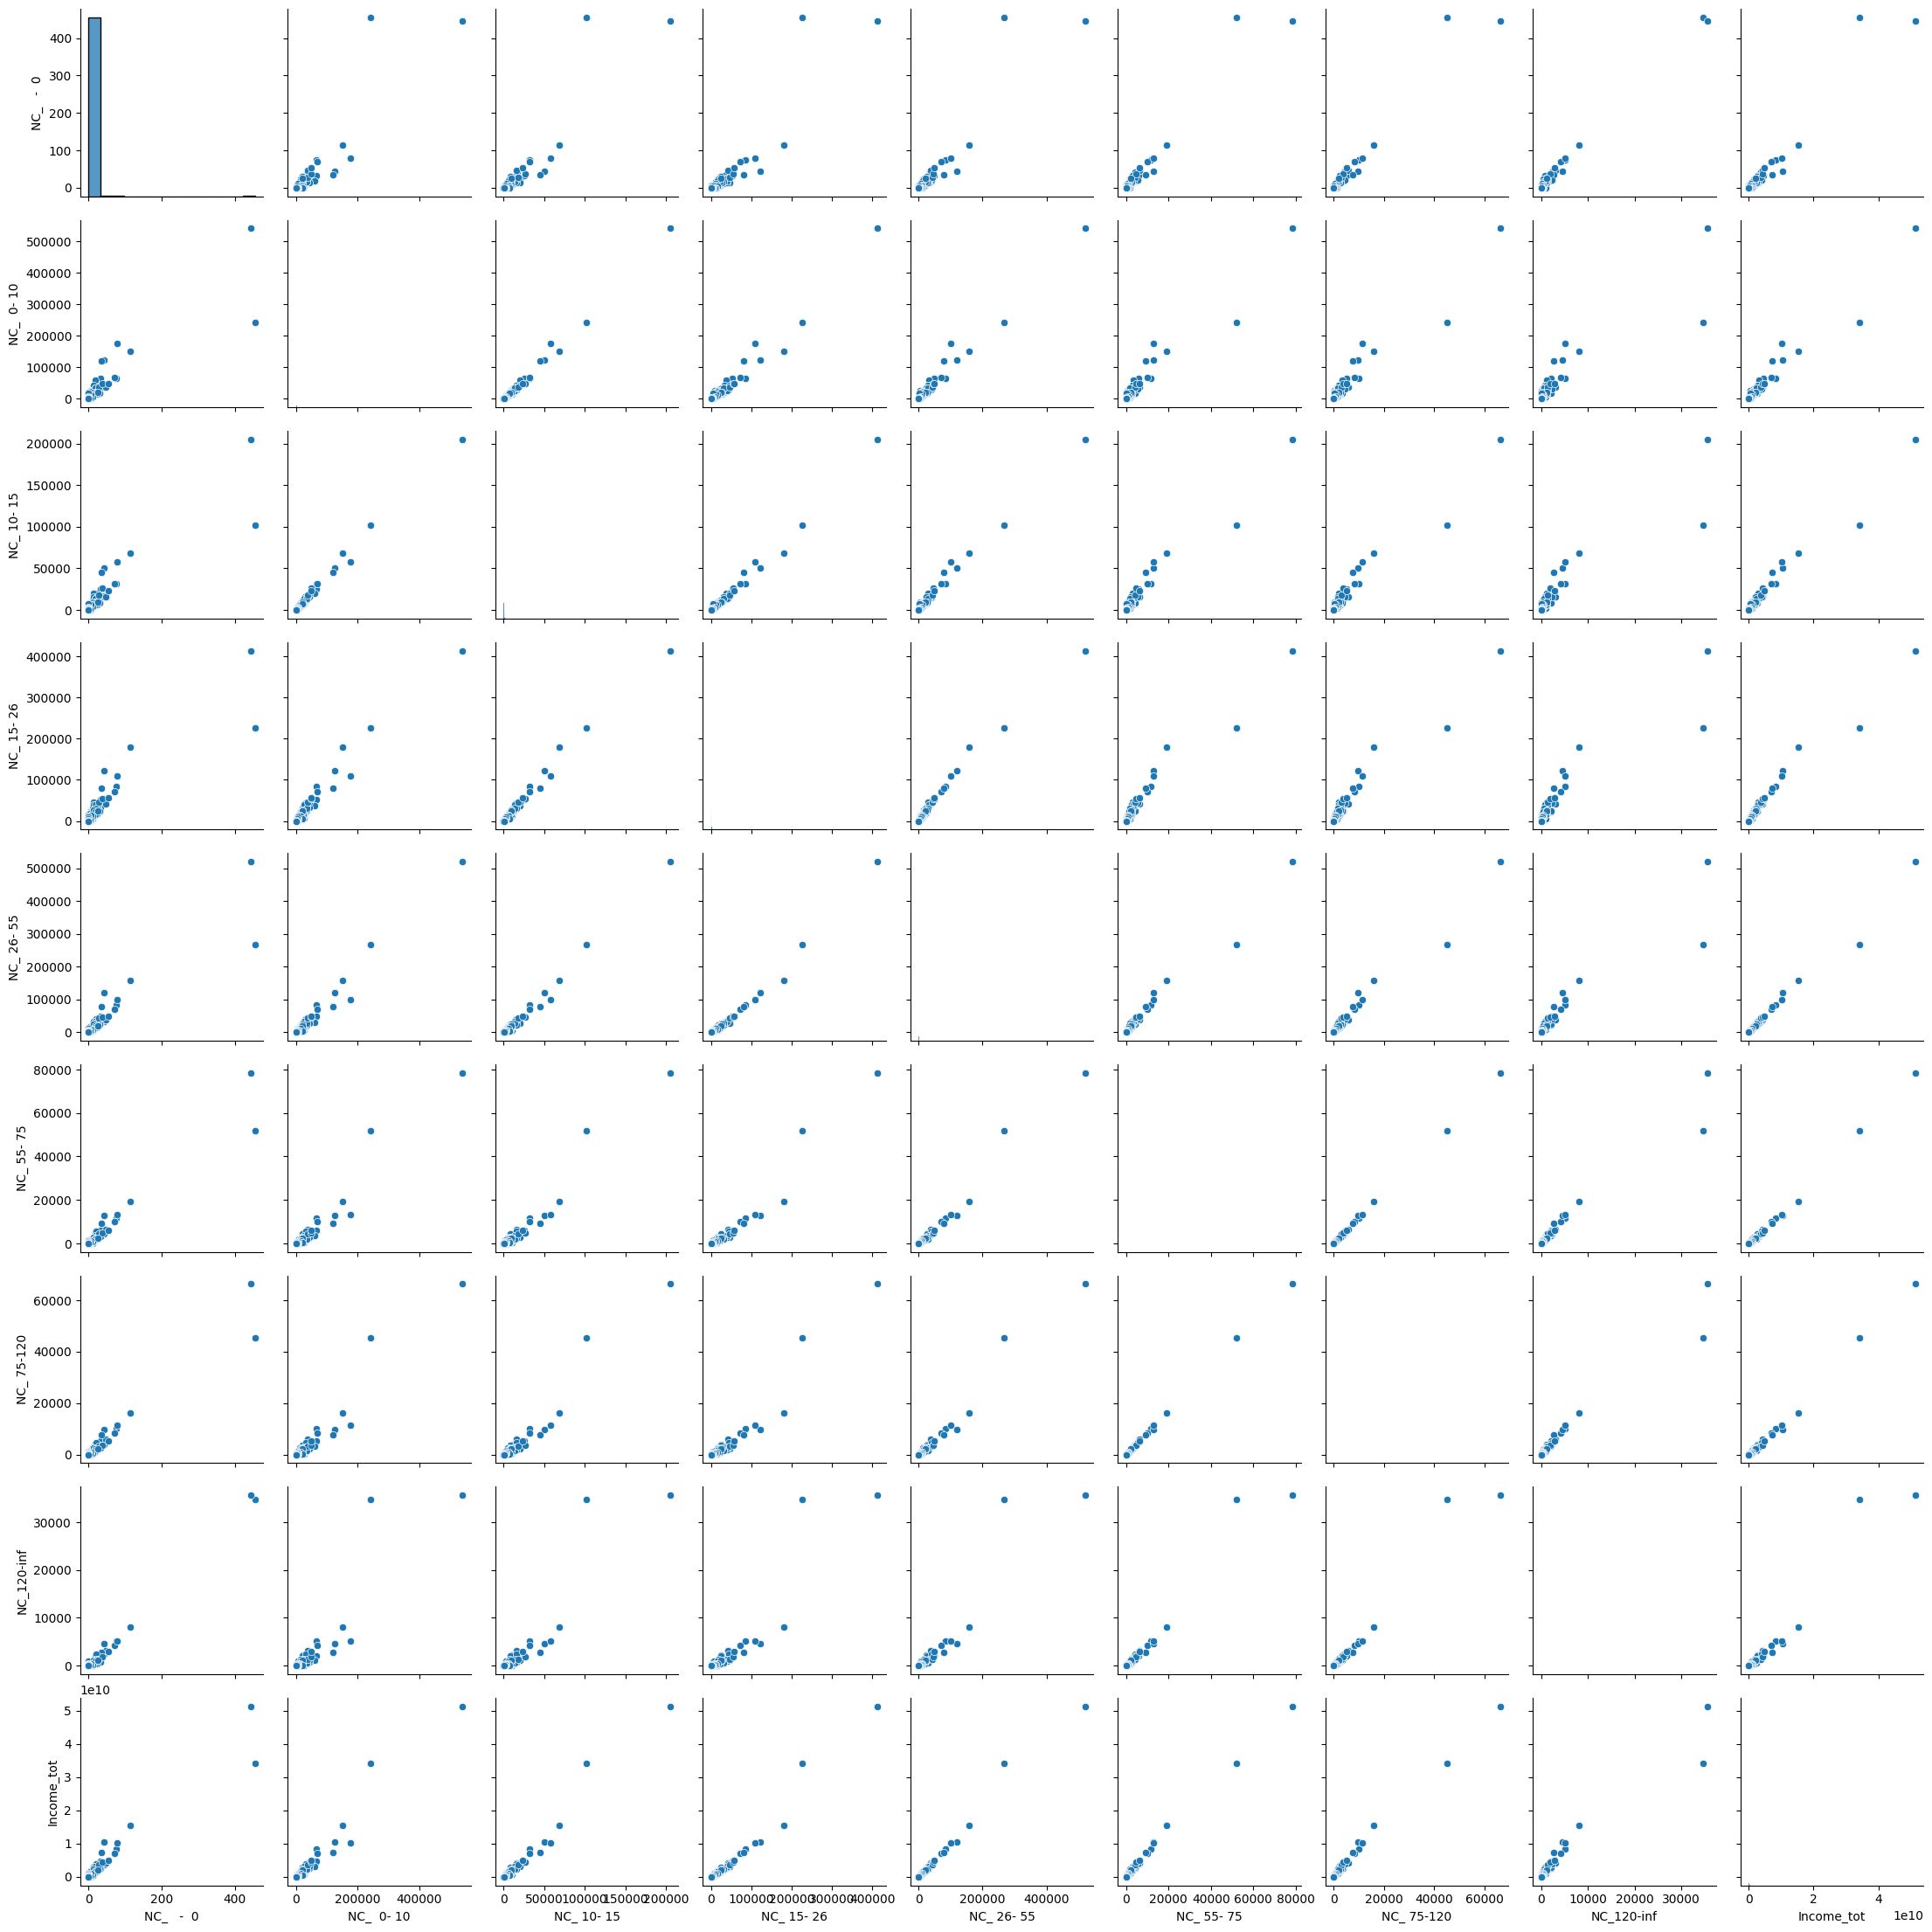

In [2]:
print('Data size: {}'.format(df.size))
sns.pairplot(df)

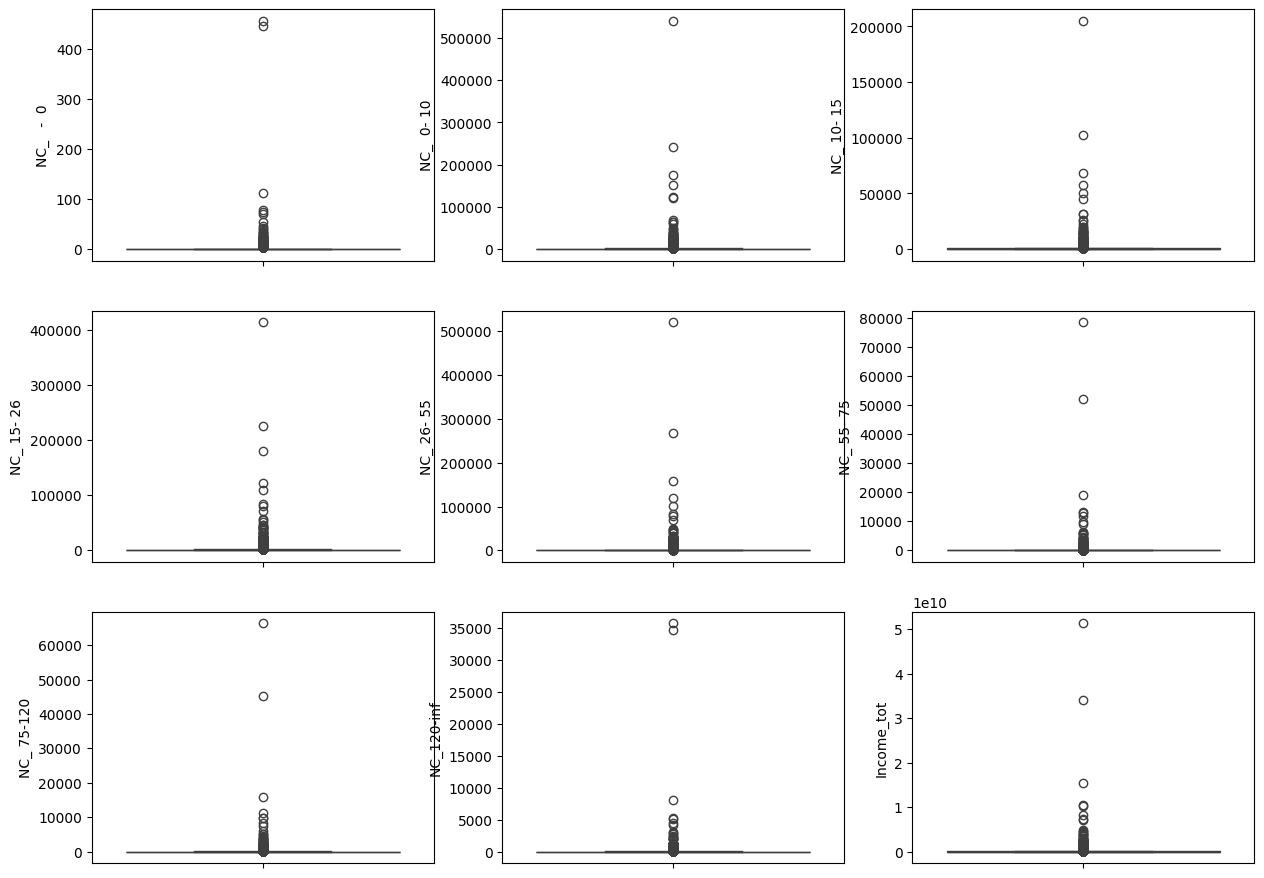

In [3]:
plt.figure(figsize=(15,15))
pos = 1
for i in df.columns:
  if(type(df[i][0]) != str):
    plt.subplot(4, 3, pos)
    sns.boxplot(df[i])
    pos+=1

The pairplot and boxplot don't seem to highlight any particular situation, the points seem to be grouped together quite often, usually in a oblique shape.

## 2. Drop the columns that are not relevant for the clustering operation, if any, and explain why you do that (4pt)

<ipython-input-4-6dc1c4c1753e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

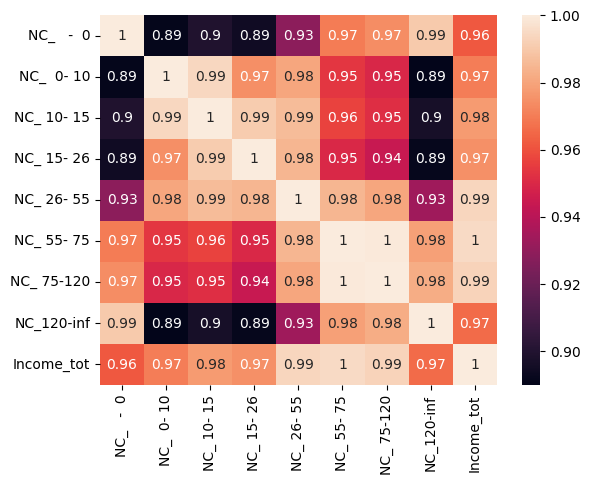

In [4]:
sns.heatmap(df.corr(), annot=True)

I will drop the following columns:

*   `Income_tot` since it's an aggregation of the others columns
*   `NC_55_75` because it has maximum correlation with `NC_75_120_inf` and `Income_tot`
* `Territorio` because it has different values for each row, and doesn't bring useful info

In [5]:
X = df.drop(columns=["Income_tot", "NC_ 55- 75", "Territorio"], axis=1)
X

,NC_ - 0,NC_ 0- 10,NC_ 10- 15,NC_ 15- 26,NC_ 26- 55,NC_ 75-120,NC_120-inf
0,0.0,3641.0,1997.0,4567.0,3268.0,400.0,177.0
1,0.0,50.0,29.0,73.0,41.0,0.0,0.0
2,0.0,511.0,276.0,792.0,656.0,48.0,31.0
3,0.0,1303.0,783.0,1820.0,754.0,33.0,13.0
4,0.0,577.0,194.0,443.0,430.0,13.0,0.0
...,...,...,...,...,...,...,...
7886,0.0,126.0,60.0,163.0,87.0,0.0,4.0
7887,0.0,155.0,104.0,295.0,151.0,13.0,4.0
7888,0.0,645.0,277.0,374.0,188.0,5.0,0.0
7889,0.0,350.0,163.0,138.0,62.0,4.0,0.0


## 3. Find the best clustering scheme and compute: a) the quality indexes usual for clustering and b) the size of the clusters (4pt)

### Utils

In [6]:
def draw_plot(x, y1, y2, x_label, y1_label, y2_label):
  fig, ax1 = plt.subplots()

  ax1.set_xlabel(x_label)
  ax1.set_ylabel(y1_label, color="red")
  ax1.plot(x, y1, color="red")

  ax2 = ax1.twinx()

  ax2.set_ylabel(y2_label, color="blue")
  ax2.plot(x, y2, color="blue")
  ax2.set_ylim([0,1])

  plt.show()

In [13]:
def draw_pie(data, labels):
  fig = plt.figure(figsize=(10,5))
  plt.pie(data,
      labels = labels,
      autopct='%1.1f%%',
      shadow=True)
  plt.legend()
  plt.show()

### K-Means

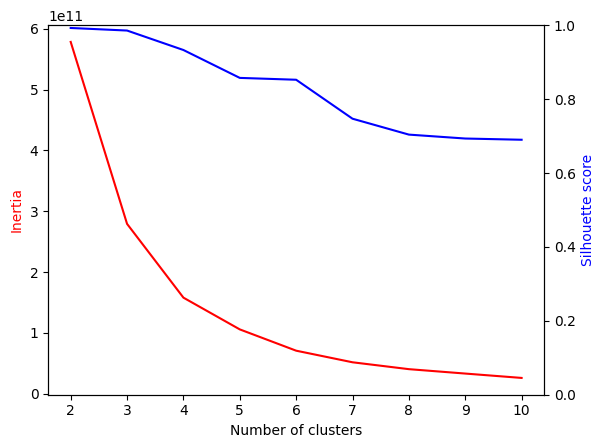

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings(action="ignore")

k_ranges = list(range(2,11))

silhuette_scores = []
distortions = []
size_deviations = []

for k in k_ranges:
  km = KMeans(n_clusters=k, random_state=random_state)
  y_km = km.fit_predict(X)

  deviation = np.sqrt(np.unique(y_km, return_counts=True)[1].var())//k

  silhuette_scores.append(silhouette_score(X, y_km))
  size_deviations.append(deviation)
  distortions.append(km.inertia_)

draw_plot(k_ranges, distortions, silhuette_scores, 'Number of clusters', 'Inertia', 'Silhouette score')

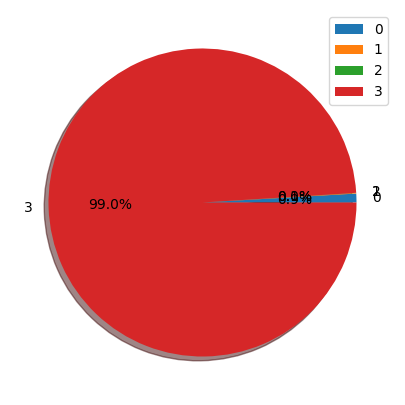

In [74]:
k = 4
km1 = KMeans(k, random_state=random_state)
y_km1 = km1.fit_predict(X)

km_res = np.unique(y_km1, return_counts=True)
draw_pie(km_res[1], km_res[0])

### DBSCAN

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid

param_grid = {'eps' : list(np.arange(1,15,1)), 'min_samples': list(np.arange(2,18,2))}
params = ParameterGrid(param_grid)

#dbscan_out = pd.DataFrame()

dbscan_out = pd.DataFrame(columns=['eps', 'min_samples', 'n_cluster', 'silhouette', 'unclust%'])

for i in range(len(params)):
  db = DBSCAN(**params[i])
  y_db = db.fit_predict(X)

  cluster_labels = np.unique(y_db)
  cluster_labels = cluster_labels[cluster_labels != -1]
  n_clusters = len(cluster_labels)

  if n_clusters > 1:
    #filter noise from X and y_db
    X_cl = X.loc[y_db != -1]
    y_db_cl = y_db[y_db != -1]

    silhuette = silhouette_score(X_cl, y_db_cl)
    uncl_p = (1 - y_db_cl.shape[0] / y_db.shape[0]) * 100    #percentage of unclustered data
    dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhuette, uncl_p]

    #print('-'*40)
    #print('eps: {} min_samples: {} n_cluster: {} silhouette: {:.2f} unclust%: {:.2f}'.format(db.eps, db.min_samples, n_clusters, silhuette, uncl_p))

In [9]:
silhuette_treshold = 0.45
unlcustered_threshold = 15
num_clusters_threshold = 10

dbscan_final = dbscan_out[(dbscan_out['silhouette'] >= silhuette_treshold)
                          & (dbscan_out['n_cluster'] <= num_clusters_threshold)
                          & (dbscan_out['unclust%'] >= unlcustered_threshold)]

dbscan_final.sort_values('silhouette', ascending=False)

,eps,min_samples,n_cluster,silhouette,unclust%
0,2.0,2.0,3.0,0.868293,99.923964
3,4.0,4.0,2.0,0.654538,99.835255
19,8.0,10.0,2.0,0.517451,98.567989
27,9.0,14.0,2.0,0.458158,98.263845
49,13.0,14.0,2.0,0.453303,94.309973


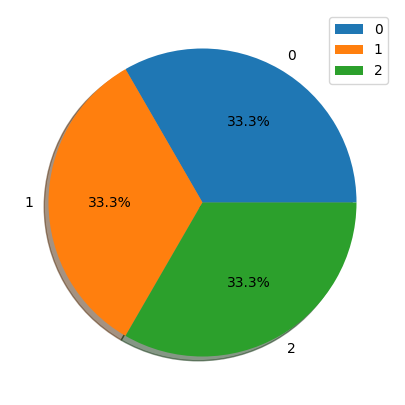

In [75]:
db1 = DBSCAN(eps = 2.0, min_samples = 2)
y_db1 = db1.fit_predict(X.to_numpy())

y_db_cl = y_db1[y_db1 != -1]

clust_sizes_km = np.unique(y_db_cl, return_counts=True)

draw_pie(clust_sizes_km[1], clust_sizes_km[0])

## 4. Apply a data transformation using the preprocessor below (6pt)

In [19]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import make_pipeline

preprocessor = make_pipeline(StandardScaler(with_std=False),
                        PowerTransformer(standardize=True))

X_fit = preprocessor.fit_transform(X)
X_fit

array([[-0.18458481,  1.42250056,  1.45416407, ...,  1.52629428,
         1.90401051,  1.953686  ],
       [-0.18458481, -1.19815717, -1.20342171, ..., -1.03548671,
        -0.96755778, -0.85185343],
       [-0.18458481, -0.3045096 , -0.16628161, ...,  0.44620933,
         0.75114637,  1.32039822],
       ...,
       [-0.18458481, -0.05978469, -0.16232812, ..., -0.65745361,
        -0.76467496, -0.85185343],
       [-0.18458481, -0.60812915, -0.62665358, ..., -0.9807136 ,
        -0.80486122, -0.85185343],
       [-0.18458481, -0.06158195, -0.48954108, ..., -0.92360001,
        -0.96755778, -0.85185343]])

## 5. Find the best clustering scheme for the transformed data, as done in step 3 (4pt)

### K-Means

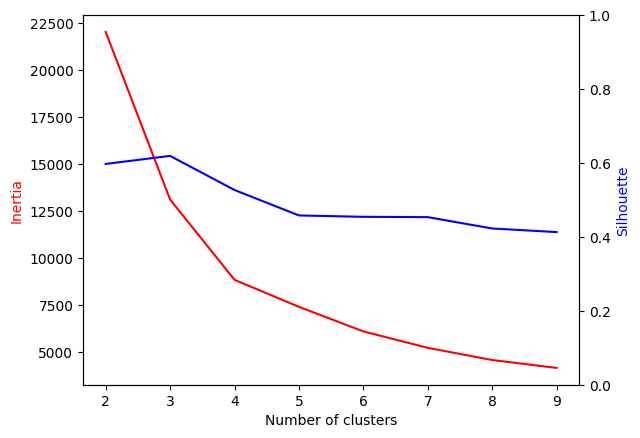

In [76]:
k_ranges = list(range(2, 10))

silhouette_scores = []
size_deviation = []
distortions = []

for k in k_ranges:
  km = KMeans(k, random_state=random_state)
  y_km = km.fit_predict(X_fit)

  sl_score = silhouette_score(X_fit, y_km, random_state=random_state)
  deviation = np.sqrt(np.unique(y_km, return_counts=True)[1].var())/k

  silhouette_scores.append(sl_score)
  distortions.append(km.inertia_)
  size_deviation.append(deviation)

draw_plot(k_ranges, distortions, silhouette_scores, 'Number of clusters', 'Inertia', 'Silhouette')

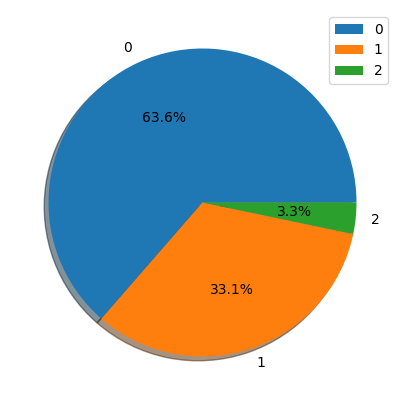

In [72]:
k = 3
km2 = KMeans(k, random_state=random_state)
y_km2 = km2.fit_predict(X_fit)

km_res = np.unique(y_km2, return_counts=True)
draw_pie(km_res[1], km_res[0])

### DBSCAN

In [65]:
params = {'eps' : list(np.arange(1,5,0.5)), 'min_samples' : list(np.arange(2,18,8))}
param_grid = ParameterGrid(params)
#print(params)

dbscan_out = pd.DataFrame()

dbscan_out = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'silhouette', 'unclust%'])

for i in range(len(param_grid)):
  #print(param_grid[i])
  db = DBSCAN(**param_grid[i])
  y_db = db.fit_predict(X_fit)

  cluster_labels = np.unique(y_db)
  cluster_labels = cluster_labels[cluster_labels != -1]
  n_clusters = len(cluster_labels)

  if n_clusters > 1:
    X_cl = X_fit[y_db != -1, :]
    y_db_cl = y_db[y_db != -1]

    unclust_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100

    silhouette = silhouette_score(X_cl, y_db_cl, random_state=random_state)
    deviation = np.sqrt(np.unique(y_db_cl, return_counts=True)[1].var())/i
    dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, unclust_p]

dbscan_out

,eps,min_samples,n_clusters,silhouette,unclust%
0,1.0,2.0,5.0,0.581977,0.139399
1,1.0,10.0,2.0,0.643984,0.253453
2,1.5,2.0,3.0,0.641442,0.088709
3,1.5,10.0,2.0,0.644587,0.152072
4,2.0,2.0,3.0,0.644509,0.050691
5,2.0,10.0,2.0,0.644834,0.114054
6,2.5,2.0,2.0,0.648445,0.038018
7,2.5,10.0,2.0,0.645363,0.088709
8,3.0,2.0,2.0,0.648445,0.038018
9,3.0,10.0,2.0,0.646006,0.063363


In [66]:
sl_trsh = 0.648
n_cl_trsh = 5

dbscan_out = dbscan_out[(dbscan_out['n_clusters'] <= n_cl_trsh)
                        & (dbscan_out['silhouette'] >= sl_trsh)]

dbscan_out.sort_values('silhouette', ascending=False)

,eps,min_samples,n_clusters,silhouette,unclust%
10,3.5,2.0,2.0,0.650050,0.025345
12,4.0,2.0,2.0,0.650050,0.025345
14,4.5,2.0,2.0,0.650050,0.025345
6,2.5,2.0,2.0,0.648445,0.038018
8,3.0,2.0,2.0,0.648445,0.038018
15,4.5,10.0,2.0,0.648445,0.038018


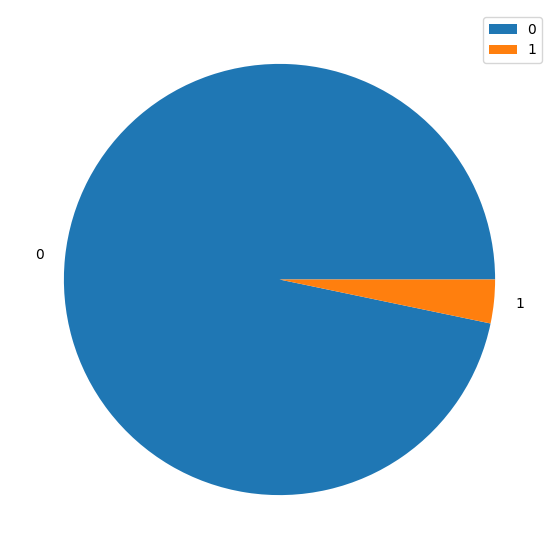

In [73]:
db2 = DBSCAN(eps=3.5, min_samples=2)
y_db2 = db2.fit_predict(X_fit)

y_db2 = y_db2[y_db2 != -1]

db_res = np.unique(y_db2, return_counts=True)
data = db_res[1]
labels = db_res[0]

plt.figure(figsize=(10,7))
plt.pie(data, labels=labels)
plt.legend()
plt.show()

## 6. show together the results of the two clustering schemes obtained and comment which of the two is better and why (4pt)

### K-Means

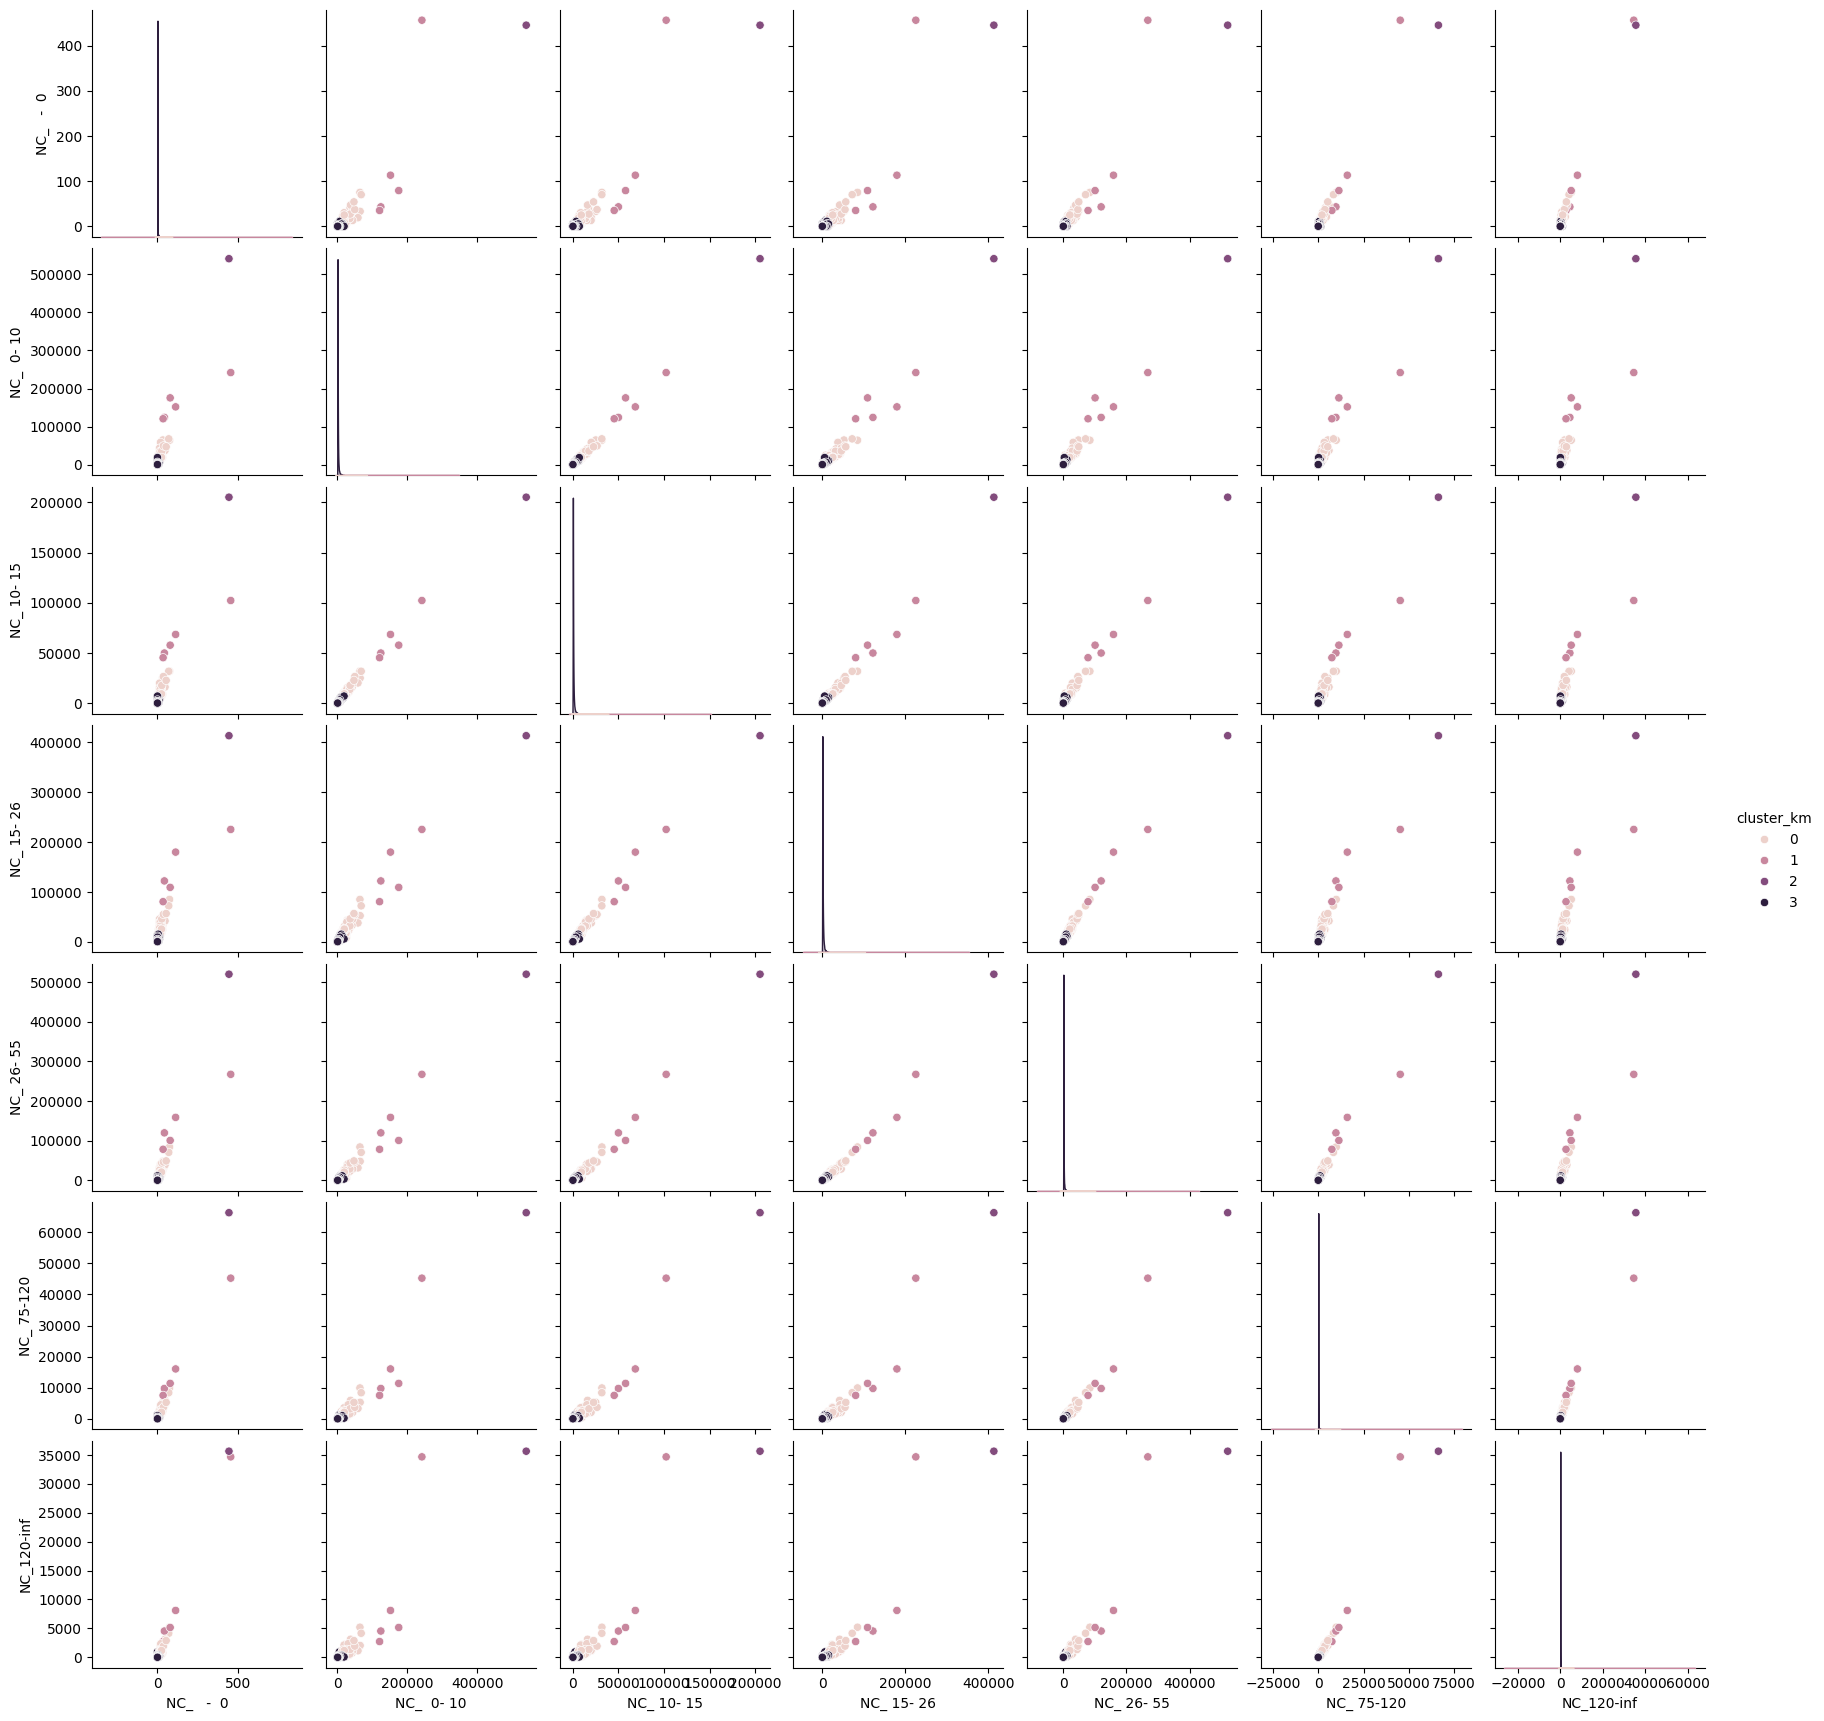

In [77]:
Xfirst = X.copy()
Xfirst['cluster_km']=y_km1
sns.pairplot(data=Xfirst, hue='cluster_km');
plt.show()

### DBSCAN

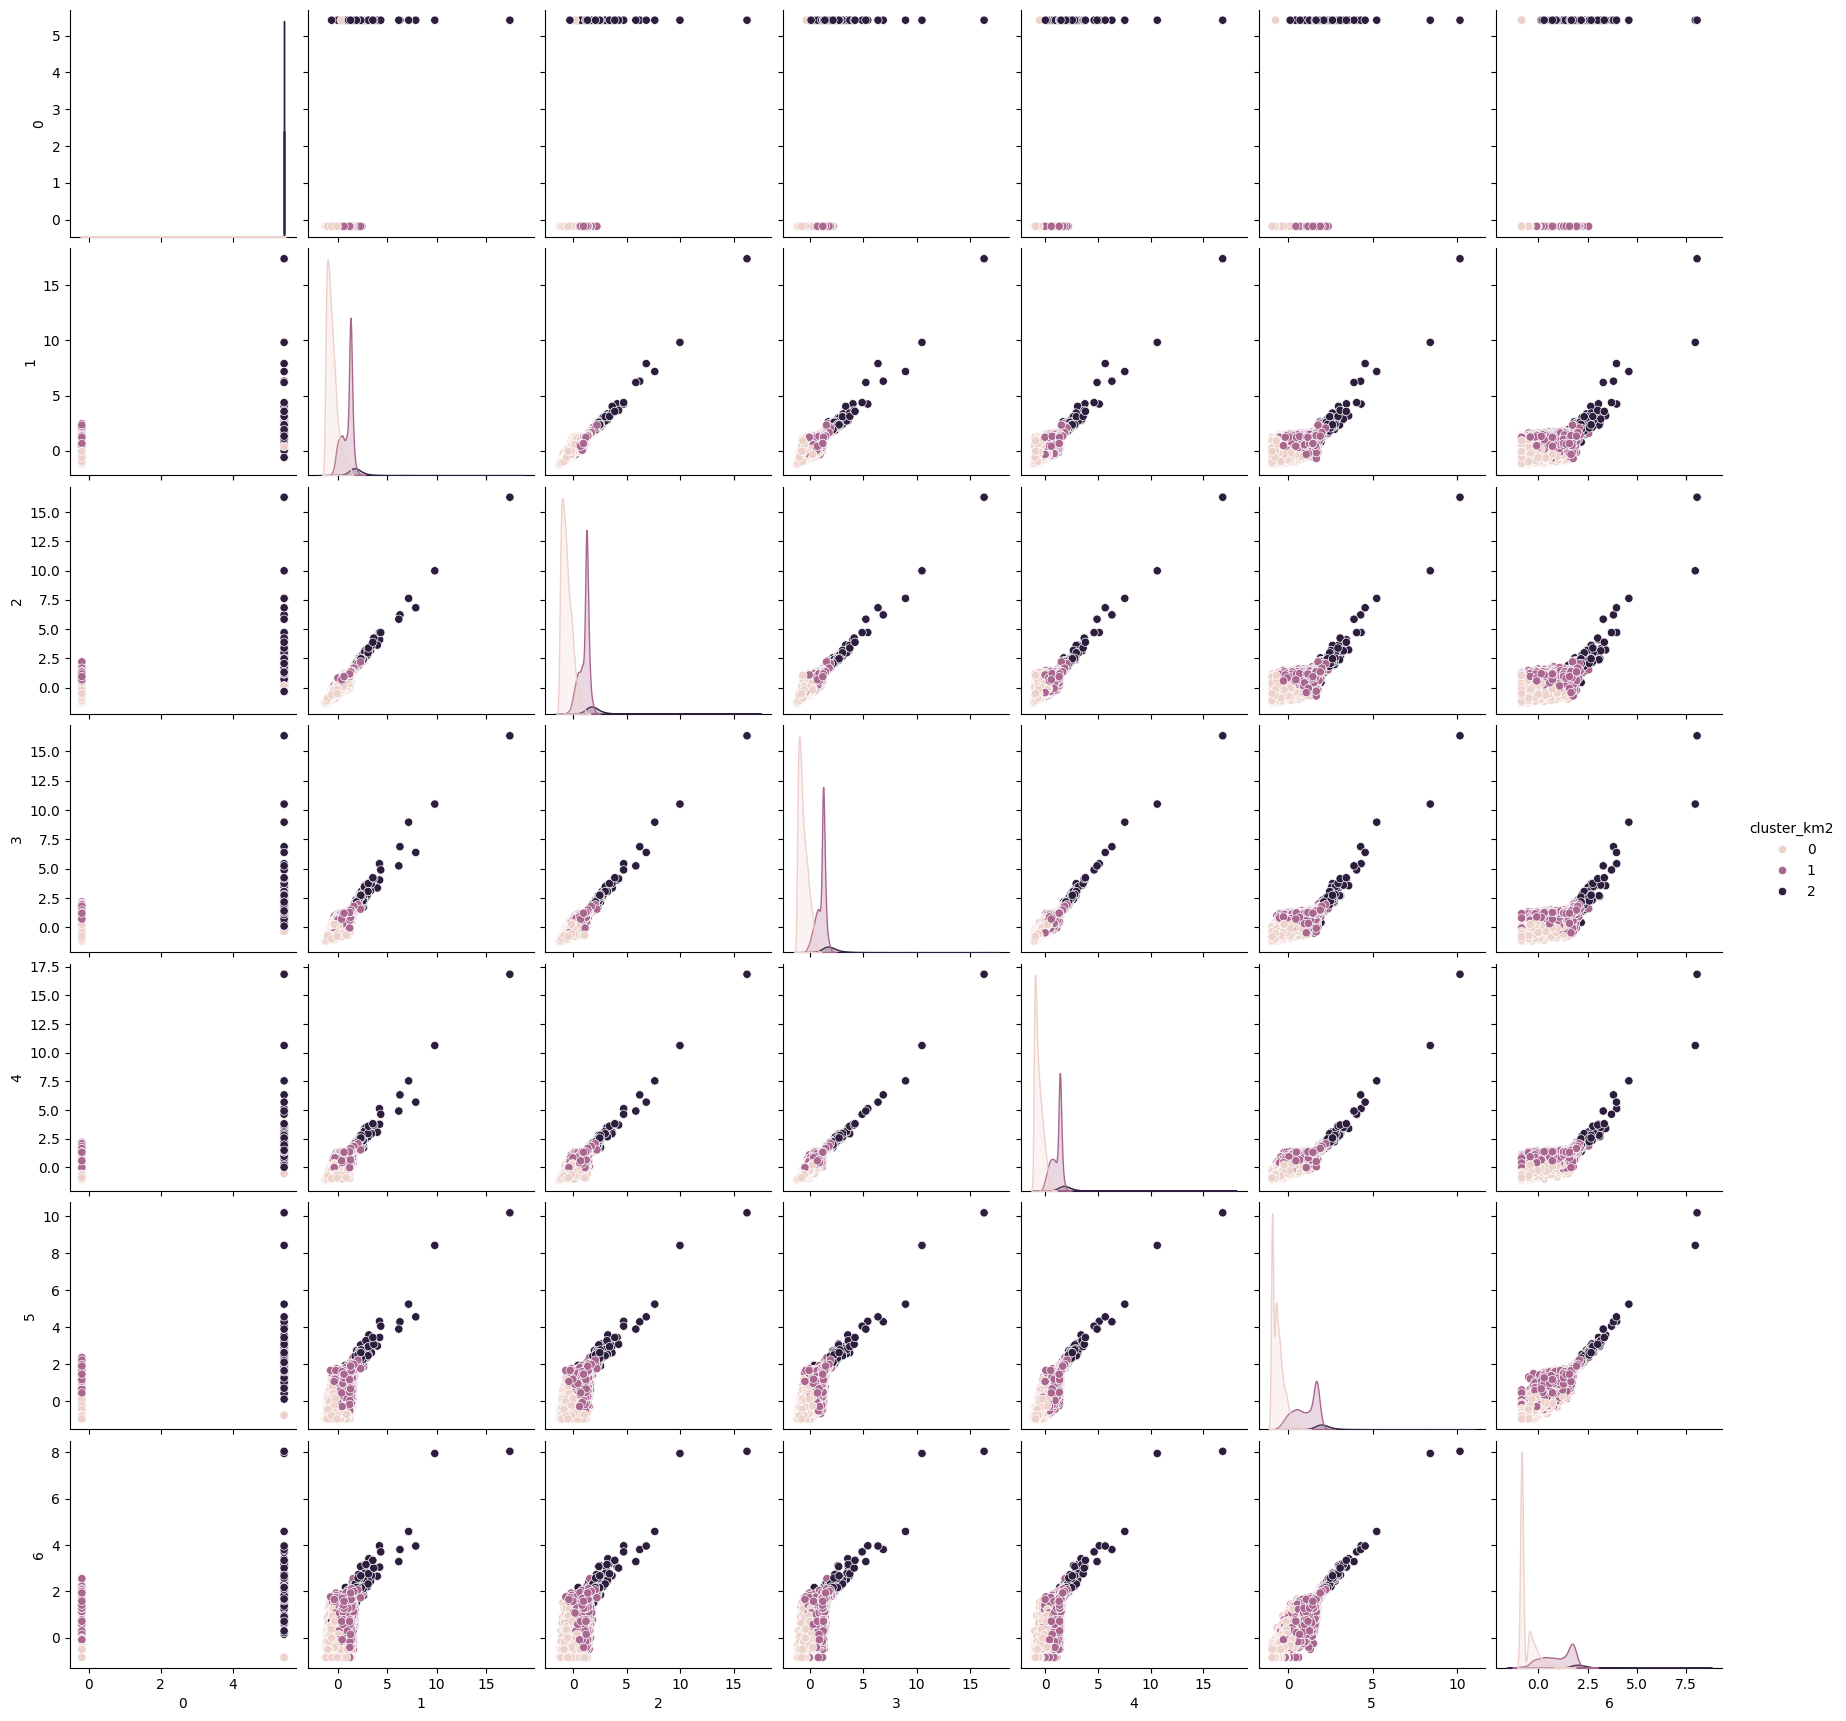

In [78]:
Xsecond = pd.DataFrame(X_fit)
Xsecond['cluster_km2']=y_km2
sns.pairplot(data=Xsecond, hue='cluster_km2');
plt.show()

The second is better thanks to the lower distortion.